# Exploration of ARIMA modeling

In this notebook, we take a more rigorous look at various formulations of ARIMA models, and compare them to a baseline of a trended persistance forecast. It's not looking good for ARIMA.

In [1]:
from core.problems import SumToSumARIMA
from core.preprocessing import make_small_train, make_small_dev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')
from time import time

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_pickle('data/master_dataset.pkl')
df.fillna(0, inplace=True)
train_df = make_small_train(df, 'combined')
test_df = make_small_dev(df)

In [3]:
prob = SumToSumARIMA(train_df)

# Trended persistance forecast

It is best practice to use a persistance or trended persistance forecast as a baseline for comparing other forecasters. Here is a trended persistance forecast implemented with an ARI model, with and auto-regressive order of 1 and a differencing order of 2.

55373.4525797


(0, 500)

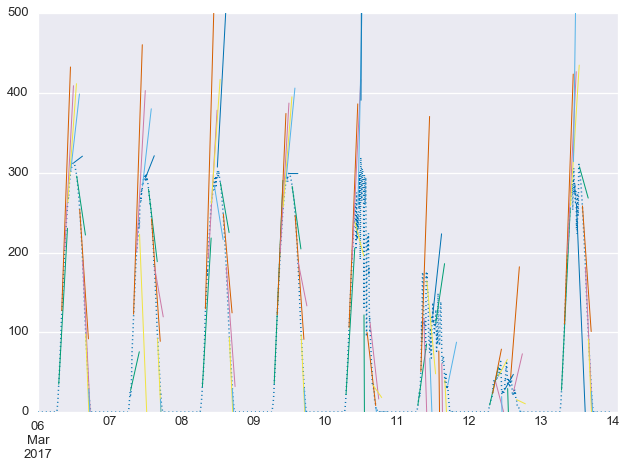

In [4]:
prob.train(order=(1, 2, 0))
prob.test(test_df['total_power'])
print prob.calc_mse()
prob.plot_test()
plt.ylim(0,500)

### A grid parameter search

Let's start by exploring some of the AR and MA parameter space. $p$ is the AR parametet (How many previous terms are used in the model) and $q$ is the MA term (the number of lagged error terms).

In [5]:
ps = [2, 12, 18, 24, 30]
qs = [0, 1, 2]
for p in ps:
    for q in qs:
        prob.train(order=(p,0,q))
        prob.test(test_df['total_power'])
        print 'p: {}, q: {}, error: {:.3f}'.format(p, q, prob.calc_mse())

p: 2, q: 0, error: 5272.125
p: 2, q: 1, error: 5338.981


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 2, q: 2, error: 3410.803
p: 12, q: 0, error: 3597.170


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 12, q: 1, error: 3697.310


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 12, q: 2, error: 3073.569


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 18, q: 0, error: 3129.871


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 18, q: 1, error: 3185.129
p: 18, q: 2, error: 3187.302
p: 24, q: 0, error: 3021.877
p: 24, q: 1, error: 3022.328
p: 24, q: 2, error: 3021.849
p: 30, q: 0, error: 3040.491


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 30, q: 1, error: 3046.809


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 30, q: 2, error: 3047.948


#### Best run:

Our best run used parameters:

- p = 24
- q = 1

Here's what the predictions looked like:

3021.87725824


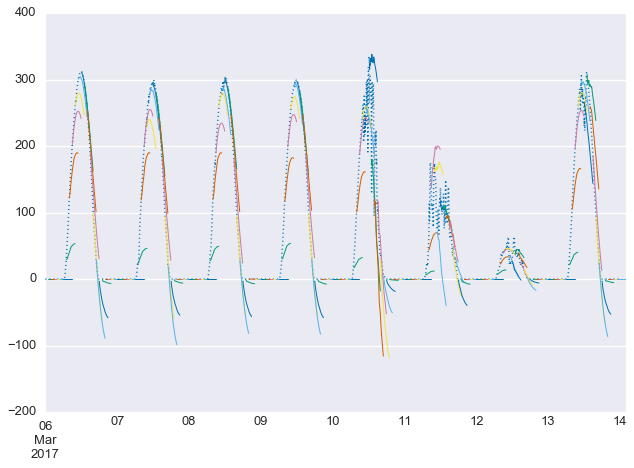

In [6]:
prob.train(order=(24,0,0))
prob.test(test_df['total_power'])
print prob.calc_mse()
prob.plot_test()

It looks like the model is doing something interesting, but the error is worse than the trended persistance model, so the ARMA formulation is not looking promising.

Now lets try a couple higher orders of $d$, the integral term. The differencing step deals with non-stationary data. We don't have that here—the data is approximately stationary—but let's try anyway.

In [7]:
for d in [0, 1, 2]:
    prob.train(order=(24,d,0))
    prob.test(test_df['total_power'])
    print 'd: {}, error: {:.3f}'.format(d, prob.calc_mse())

d: 0, error: 3021.877
d: 1, error: 3968.211
d: 2, error: 5872.091


This does not help, if we inspect the $d=2$ run, we can see why:

5872.09090229


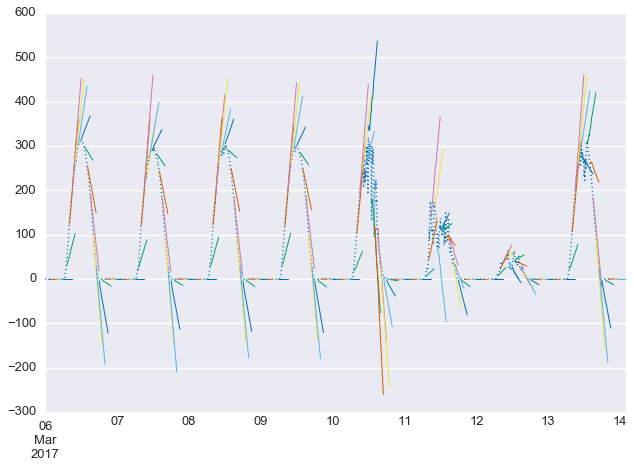

In [8]:
prob.train(order=(24, 2, 0))
prob.test(test_df['total_power'])
print prob.calc_mse()
prob.plot_test()

Increasing the integral term gives the model a lot of "momentum" causing the forecast to tend to continue on the trajectory from the previous data.

### Other notes

- I tried a few other solvers, and didn't get any significantly different or better results. A couple of the solvers didn't converge at all.
- There are also seasonal parameters and exogenous parameters that can be included in the model. I did a bit of testing with both and couldn't get any improvement